In [1]:
import logging, requests, os, sys, boto3
import matplotlib.pyplot as plt
sys.path.append('C:/Users/tgwon/wri/cif/cities-cif')
os.environ['GOOGLE_APPLICATION_USER'] = 'script-service-account@wri-gee.iam.gserviceaccount.com'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/tgwon/.google/credkey.json'
sys.path = ['C:\\Users\\tgwon\\wri\\indicators', 'C:\\Users\\tgwon\\wri\\cif\\cities-cif', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\python310.zip', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\DLLs', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\lib', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\lib\\site-packages', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\lib\\site-packages\\win32', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\lib\\site-packages\\win32\\lib', 'C:\\Users\\tgwon\\anaconda3\\envs\\cities-cif\\lib\\site-packages\\Pythonwin',]

from botocore.exceptions import ClientError
import pandas as pd
import geopandas as gpd
from city_metrix.layers.layer_geometry import GeoExtent
from city_metrix.metrics.expected_heat_hazard import future_heatwave_frequency, future_heatwave_maxduration

Authenticating to GEE with configured credentials file.


In [2]:
LOCAL_PREFIX = 'C:/Users/tgwon/wri/indicators'
START_YEARS = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

In [3]:
# Set up for S3 uploads

SESSION = boto3.Session(profile_name='CitiesUserPermissionSet-540362055257')
BUCKET = 'wri-cities-indicators'
S3_OUTPUT_PREFIX = 'devdata/ted_misc'

def upload_s3(session, file_name, bucket, object_name):
    s3_client = session.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name, ExtraArgs={'ACL': 'public-read'})
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [4]:
# Get Cape Town boundary

CITYDATA_URL = 'https://cities-data-api.wri.org/cities'
citydata = requests.get(CITYDATA_URL).json()
cities = citydata['cities']
capetown = [c for c in cities if c['name']=='Cape Town'][0]
capetown_gdf = gpd.GeoDataFrame.from_file(capetown['layers_url']['geojson'])

In [5]:
# Get heatwave frequency data
# Store locally
# Upload to S3

results = []
for year in START_YEARS:
    print(year)
    results.append(future_heatwave_frequency(start_year=year, end_year=year+9, zones=capetown_gdf))
res_freq = pd.DataFrame(\
    {\
        'decade': [f'{year}__{year+9}' for year in START_YEARS],\
        'estimate_rank1': [float(result.model_1[0]) for result in results],\
        'estimate_rank2': [float(result.model_2[0]) for result in results],\
        'estimate_rank3': [float(result.model_3[0]) for result in results]\
    }\
)
oname = 'heatwave_frequency__ZAF-Cape_Town.json'
with open(f'{LOCAL_PREFIX}/{oname}', 'w') as ofile:
    ofile.write(res_freq.to_json())
upload_s3(SESSION, f'{LOCAL_PREFIX}/{oname}', BUCKET, f'{S3_OUTPUT_PREFIX}/{oname}')

2020
0 of 1
2030
0 of 1
2040
0 of 1
2050
0 of 1
2060
0 of 1
2070
0 of 1
2080
0 of 1
2090
0 of 1


True

<Figure size 1500x480 with 0 Axes>

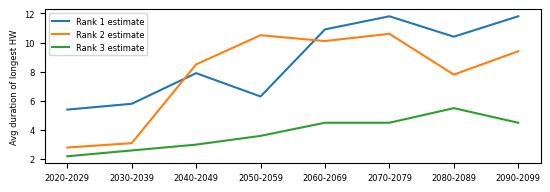

In [11]:
# Visualize HW freqs

plt.figure().set_figwidth(15)
plt.figure().set_figheight(2)
plt.ylabel('Avg duration of longest HW')
plt.rcParams.update({'font.size': 6})
decades = [i.replace('__', '-') for i in res_freq.decade]

plt.plot(decades, res_freq.estimate_rank1, label='Rank 1 estimate')
plt.plot(decades, res_freq.estimate_rank2, label='Rank 2 estimate')
plt.plot(decades, res_freq.estimate_rank3, label='Rank 3 estimate')

plt.legend()
plt.show()

In [8]:
# Get heatwave max-duration data
# Store locally
# Upload to S3

results = []
for year in START_YEARS:
    print(year)
    results.append(future_heatwave_maxduration(start_year=year, end_year=year+9, zones=capetown_gdf))
res_maxdur = pd.DataFrame(\
    {\
        'decade': [f'{year}__{year+9}' for year in START_YEARS],\
        'estimate_rank1': [float(result.model_1[0]) for result in results],\
        'estimate_rank2': [float(result.model_2[0]) for result in results],\
        'estimate_rank3': [float(result.model_3[0]) for result in results]\
    }\
)
oname = 'heatwave_maxduration__ZAF-Cape_Town.json'
with open(f'{LOCAL_PREFIX}/{oname}', 'w') as ofile:
    ofile.write(res_maxdur.to_json())
upload_s3(SESSION, f'{LOCAL_PREFIX}/{oname}', BUCKET, f'{S3_OUTPUT_PREFIX}/{oname}')

2020
0 of 1
2030
0 of 1
2040
0 of 1
2050
0 of 1
2060
0 of 1
2070
0 of 1
2080
0 of 1
2090
0 of 1


True

<Figure size 1500x480 with 0 Axes>

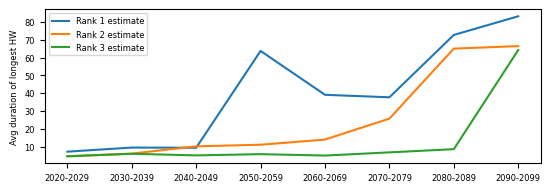

In [10]:
# Visualize HW max-durations

plt.figure().set_figwidth(15)
plt.figure().set_figheight(2)
plt.ylabel('Avg duration of longest HW')
plt.rcParams.update({'font.size': 6})
decades = [i.replace('__', '-') for i in res_maxdur.decade]

plt.plot(decades, res_maxdur.estimate_rank1, label='Rank 1 estimate')
plt.plot(decades, res_maxdur.estimate_rank2, label='Rank 2 estimate')
plt.plot(decades, res_maxdur.estimate_rank3, label='Rank 3 estimate')

plt.legend()
plt.show()